In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Assignment4AI/"

archive.zip    Ass4w12.ipynb  kaggle
Ass4w11.ipynb  Ass4w2.ipynb   Untitled0.ipynb


In [ ]:
pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#keras preprossesing wouldnt install for me here so i use pillow instead
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt
import os

In [ ]:
pic_size = 48

base_path = "/content/drive/MyDrive/Assignment4AI/kaggle/"

plt.figure(0, figsize=(12,20))
cpt = 0

<Figure size 1200x2000 with 0 Axes>

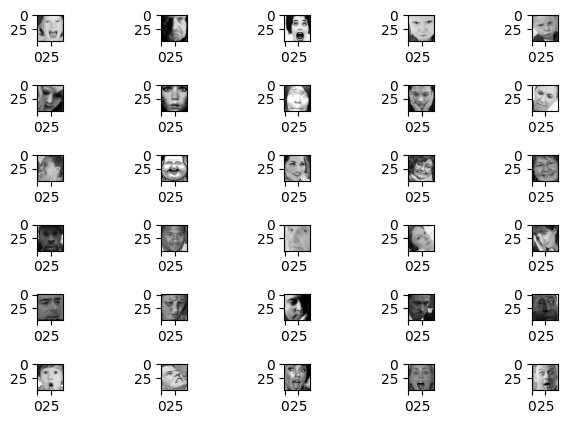

In [ ]:
for expression in os.listdir(base_path + "Training/Training/"):
    for i in range(1,6):
        cpt += 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path+'Training/Training/'+expression+"/"+os.listdir(base_path+"Training/Training/"+expression)[i],target_size=(pic_size,pic_size))
        plt.imshow(img,cmap="gray")
        pass
    pass

plt.tight_layout()
plt.show()

In [ ]:
for expression in os.listdir(base_path+"Training/Training/"):
    print(str(len(os.listdir(base_path+"Training/Training/"+expression)))+" "+expression+" images")
    pass

3995 Angry images
4097 Fear images
7215 Happy images
4965 Neutral images
4830 Sad images
3171 Suprise images


In [ ]:
datasets = [base_path + 'Training/Training',base_path + '/Testing/Testing']

output = []

class_names = ['Angry','Fear','Happy','Neutral','Sad','Suprise']

class_name_labels = {class_name:j for j,class_name in enumerate(class_names)}

nb_classes = len(class_names)
class_name_labels

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Suprise': 5}

In [ ]:
from tqdm import tqdm
import cv2

def load_dataset():
    
    for dataset in datasets:
        
        print("Loading {}".format(dataset))
        images,labels = [],[]
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(os.path.join(dataset,folder),file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img,(48,48))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)
        
        output.append((images,labels))
        pass
    
    return output
    pass

In [ ]:
(train_images,train_labels),(test_images,test_labels) = load_dataset()

Loading /content/drive/MyDrive/Assignment4AI/kaggle/Training/Training


100%|██████████| 3171/3171 [00:08<00:00, 383.14it/s]


Loading /content/drive/MyDrive/Assignment4AI/kaggle//Testing/Testing


100%|██████████| 831/831 [00:02<00:00, 375.87it/s]


In [ ]:
import pandas as pd

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

_, train_count = np.unique(train_labels,return_counts=True)
_, test_count = np.unique(test_labels,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = class_names
df

,0,1,Name
0,3995,958,Angry
1,4097,1024,Fear
2,7215,1774,Happy
3,4965,1233,Neutral
4,4830,1247,Sad
5,3171,831,Suprise


<Axes: xlabel='Name'>

<Figure size 640x480 with 0 Axes>

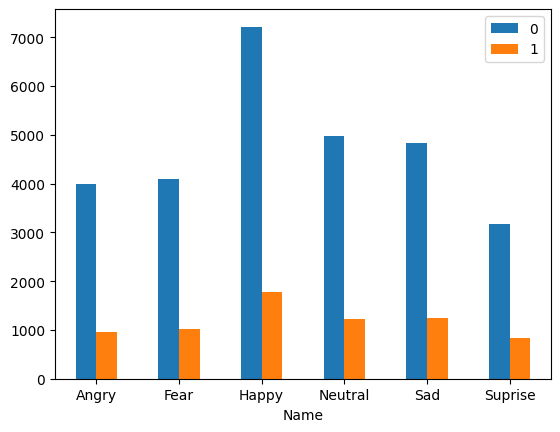

In [ ]:
plt.figure()
df.set_index('Name').plot.bar(rot=0)

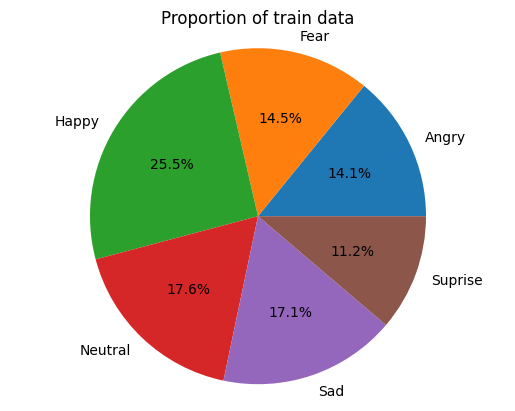

In [ ]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0),
       labels=class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of train data")
plt.show()

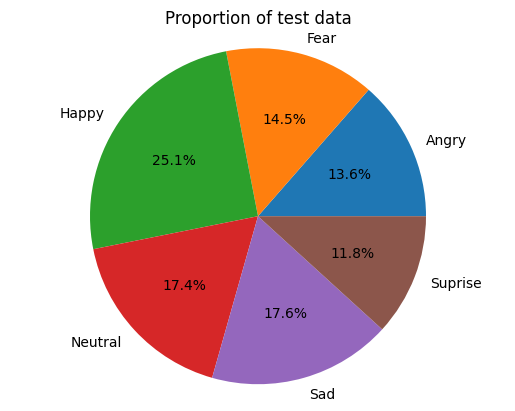

In [ ]:
plt.pie(test_count,
       explode=(0,0,0,0,0,0),
       labels=class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of test data")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 64

datagen_train = ImageDataGenerator(rescale = 1./255)
datagen_test = ImageDataGenerator(rescale = 1./255)

train_generator = datagen_train.flow_from_directory(base_path + "Training/Training",
                                                   target_size = (pic_size,pic_size),
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode = "categorical",
                                                   shuffle=True)
test_generator = datagen_test.flow_from_directory(base_path + "Testing/Testing",
                                                 target_size = (pic_size,pic_size),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=True)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [ ]:
train_generator.class_indices

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Suprise': 5}

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Sequential, Model

from keras.initializers import *


In [ ]:
def identity_block(X,k,filters,stage,block):
    
    conv_name_base = 'res_'+str(stage)+block+'_branch'
    bn_name_base = 'bn_'+str(stage)+block+'_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    # First Component of Main Path
    X = Conv2D(filters=F1,kernel_size=(3,3),strides=(1,1),
               padding='same',name=conv_name_base+'2a',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    # Second Component of Main Path
    X = Conv2D(filters=F2,kernel_size=(k,k),strides=(1,1),
              padding='same',name=conv_name_base+'2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    # Third Component of Main Path
    X = Conv2D(filters=F3,kernel_size=(3,3),strides=(1,1),
              padding='same',name=conv_name_base+'2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2c')(X)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
    pass

In [ ]:
def convolutional_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'res_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + '_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(filters=F1,kernel_size=(3,3),strides=(s,s),
              padding='same',name=conv_base_name+'2a',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    
    # Second Component of main path
    X = Conv2D(filters=F2,kernel_size=(k,k),strides=(1,1),
              padding='same',name=conv_base_name+'2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2b')(X)
    X = Activation('relu')(X)
    
    # Third Component of main path
    X = Conv2D(filters=F3,kernel_size=(3,3),strides=(1,1),
              padding='same',name=conv_base_name+'2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2c')(X)
    
    # Shortcut path
    X_shortcut = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),
                       padding='same',name=conv_base_name+'1',
                       kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_base_name+'1')(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
    pass

In [ ]:
def ResNet(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3,3))(X_input)
    
    # Stage 1
    X = Conv2D(64,(3,3),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3))(X)
    
    
    # Stage 2
    X = convolutional_block(X,k=3,filters=[32,32,64],stage=2,block='A',s=1)
    X = identity_block(X,k=3,filters=[32,32,64],stage=2,block='B')
    X = identity_block(X,k=3,filters=[32,32,64],stage=2,block='C')
    
    # Stage 3
    X = convolutional_block(X,k=3,filters=[64,64,128],stage=3,block='A',s=1)
    X = identity_block(X,k=5,filters=[64,64,128],stage=3,block='B')
    X = identity_block(X,k=3,filters=[64,64,128],stage=3,block='C')
    X = identity_block(X,k=5,filters=[64,64,128],stage=3,block='D')
    
    # Stage 4
    X = convolutional_block(X,k=5,filters=[128,128,256],stage=4,block='A',s=1)
    X = identity_block(X,k=3,filters=[128,128,256],stage=4,block='B')
    X = identity_block(X,k=3,filters=[128,128,256],stage=4,block='C')
    
    X = AveragePooling2D((2,2),name='avg_pooling1')(X)
    
    X = Flatten()(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_input,outputs=X,name='ResNet')
    
    return model
    pass

In [ ]:
model = ResNet(input_shape=(48,48,1),classes=6)

In [ ]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 64)   640         ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 26, 26, 64)   256         ['conv1[0][0]']                  
                                                                                             

In [ ]:
opt = Adam(lr=0.003)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list=[checkpoint]

In [ ]:
#only took 10 epochs since when i did 25 it stopped at 21 and wouldnt continue and i didnt want to wait that long again
epochs = 10
batch_size = 128

history = model.fit(x=train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_generator.n // test_generator.batch_size,
                    callbacks=callbacks_list)


Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 2.1478 - accuracy: 0.2762
Epoch 1: val_accuracy improved from -inf to 0.28565, saving model to model_weights.h5
441/441 [==============================] - 86s 174ms/step - loss: 2.1478 - accuracy: 0.2762 - val_loss: 1.6989 - val_accuracy: 0.2857
Epoch 2/10
441/441 [==============================] - ETA: 0s - loss: 1.4699 - accuracy: 0.4214
Epoch 2: val_accuracy improved from 0.28565 to 0.40696, saving model to model_weights.h5
441/441 [==============================] - 64s 146ms/step - loss: 1.4699 - accuracy: 0.4214 - val_loss: 1.9540 - val_accuracy: 0.4070
Epoch 3/10
441/441 [==============================] - ETA: 0s - loss: 1.3247 - accuracy: 0.4792
Epoch 3: val_accuracy improved from 0.40696 to 0.41534, saving model to model_weights.h5
441/441 [==============================] - 73s 167ms/step - loss: 1.3247 - accuracy: 0.4792 - val_loss: 1.4809 - val_accuracy: 0.4153
Epoch 4/10
441/441 [==========================

In [ ]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

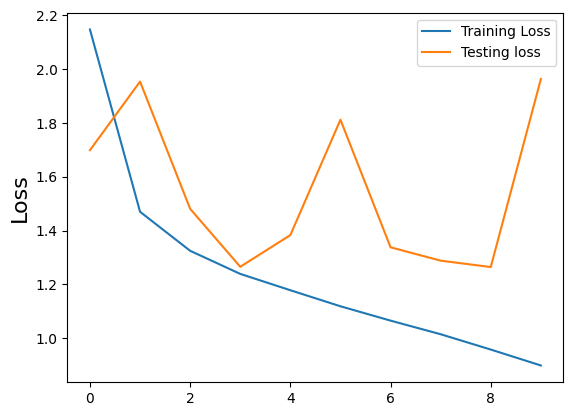

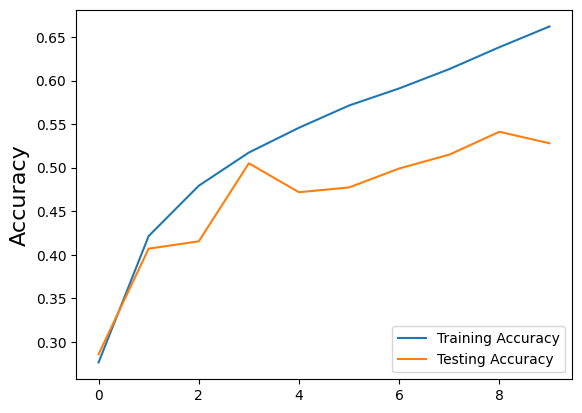

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(20,20))
# plt.subplot(1,2,1)
# plt.suptitle('Optimizer: Adam',fontsize=18)
plt.figure()
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Testing loss')
plt.legend(loc='upper right')

# plt.subplot(1,2,2)
plt.figure()
plt.ylabel('Accuracy',fontsize=16)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Testing Accuracy')
plt.legend(loc='lower right')

plt.show()

<ipython-input-28-1c4551f63426>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator=test_generator)


<Figure size 640x480 with 0 Axes>

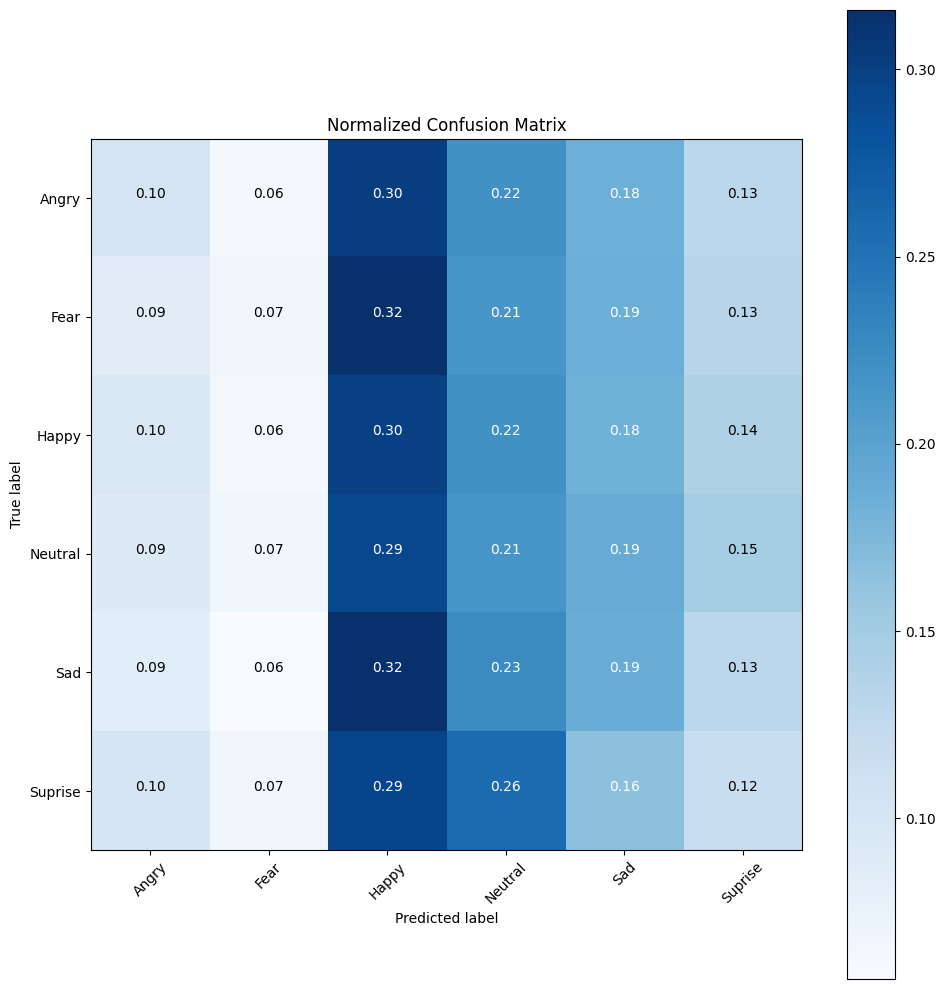

In [ ]:
predictions = model.predict_generator(generator=test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion matirx',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names, title='Normalized Confusion Matrix')
plt.show()

In [ ]:
test_acc = model.evaluate_generator(test_generator)
print("Test accuracy: ",test_acc[1])

<ipython-input-29-eae33f9b53a1>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_acc = model.evaluate_generator(test_generator)


Test accuracy:  0.528371274471283


In [ ]:
pred_generator = datagen_test.flow_from_directory(base_path + "Testing/Testing",
                                                 target_size = (pic_size,pic_size),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [ ]:
pred_generator.reset()
pred_class = model.predict_generator(pred_generator,verbose=1,steps=len(pred_generator))

<ipython-input-31-aef297d68c47>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_class = model.predict_generator(pred_generator,verbose=1,steps=len(pred_generator))


56/56 [==============================] - 12s 194ms/step


In [ ]:
labels = pred_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [ ]:
pred_class = np.argmax(pred_class,axis=1)

pred_class = [labels[k] for k in pred_class]

filenames = pred_generator.filenames
actual_class = [labels[h] for h in pred_generator.classes]

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":pred_class,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Neutral,Angry
1,Angry/Angry-10.jpg,Neutral,Angry
2,Angry/Angry-100.jpg,Angry,Angry
3,Angry/Angry-101.jpg,Angry,Angry
4,Angry/Angry-102.jpg,Neutral,Angry


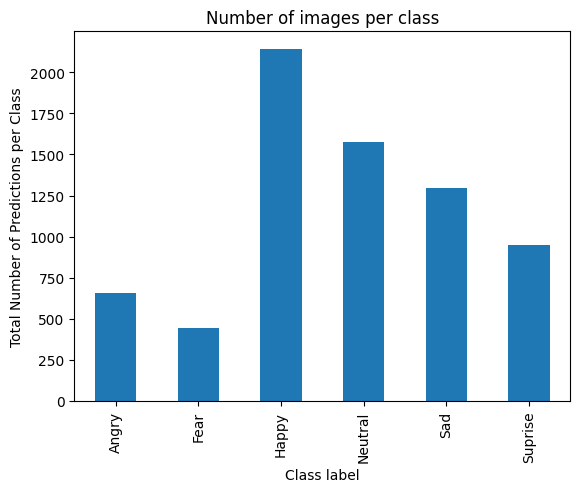

In [ ]:
pred_class_result = pred_result["Filename"].groupby(pred_result["Predictions"]).count()

plt.figure()
pred_results_visualisations = pred_class_result.plot(kind='bar')

plt.title("Number of images per class")
plt.xlabel("Class label")
plt.ylabel("Total Number of Predictions per Class")

plt.show()

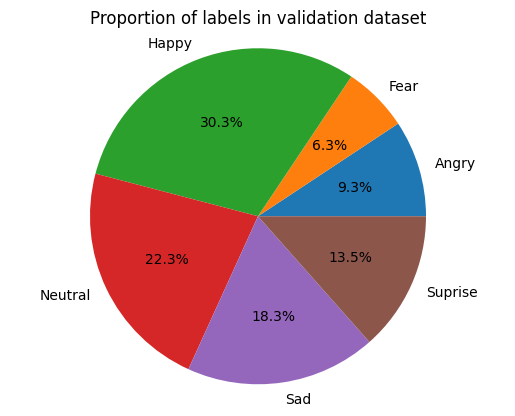

In [ ]:
_,result_count = np.unique(pred_class,return_counts=True)

plt.pie(result_count,
       explode=(0,0,0,0,0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of labels in validation dataset')
plt.show()

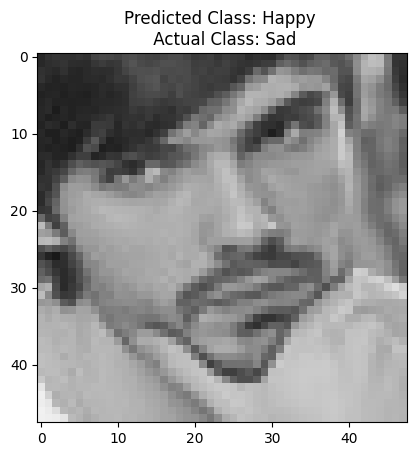

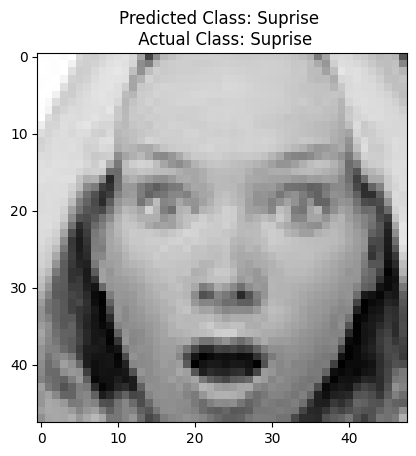

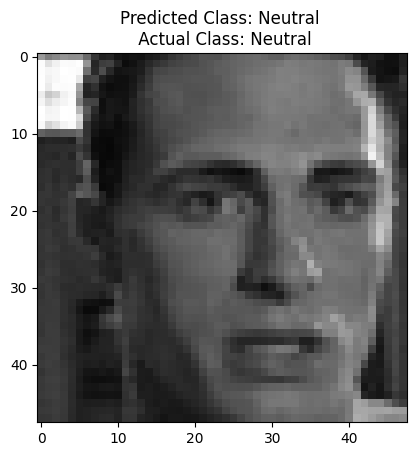

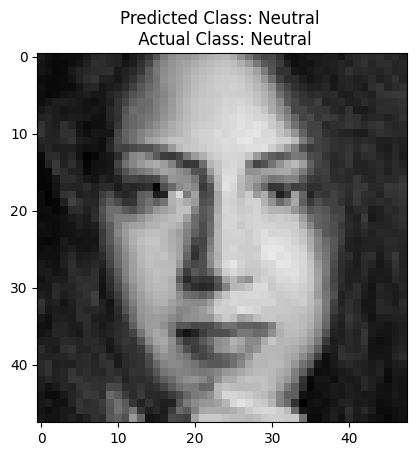

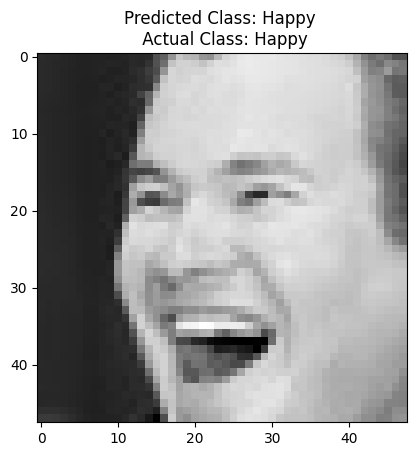

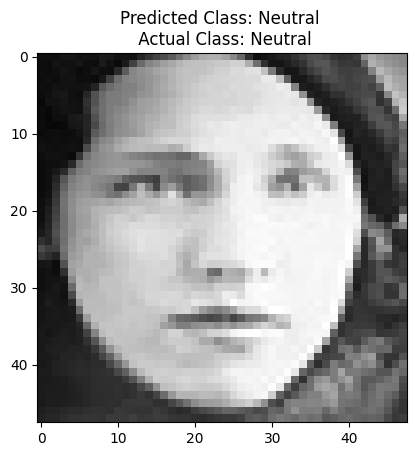

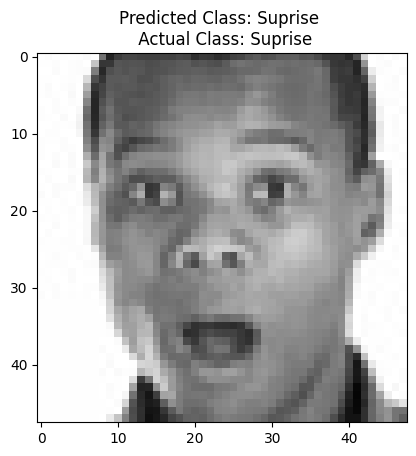

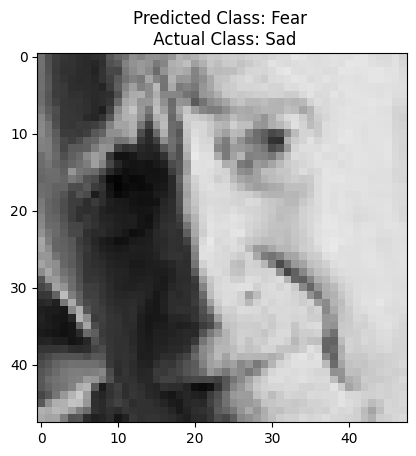

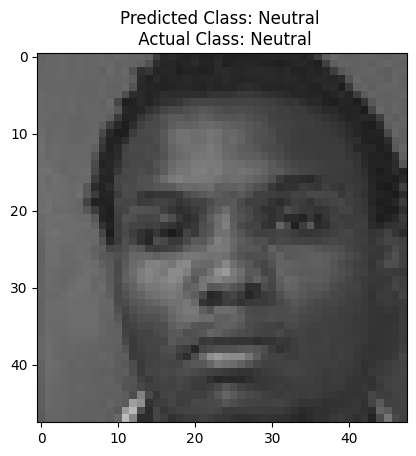

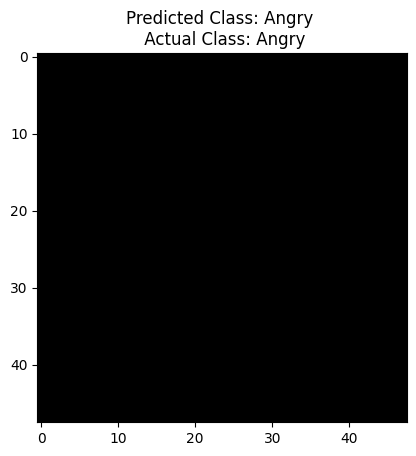

In [ ]:
from random import randint

l = len(filenames)
base_path = "/content/drive/MyDrive/Assignment4AI/kaggle/Testing/Testing/"
for i in range(10):
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


I dont have enough memory for this to work but i think this should work with enoguh memory and time but a friend comfirmed that it works

In [ ]:
import umap

In [ ]:
train_features = model.predict_generator(train_generator)
test_features = model.predict_generator(test_generator)

umapModel = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.1)
train_umap = umapModel.fit_transform(train_features)
test_umap = umapModel.transform(test_features)

plt.figure(figsize=(8, 8))
plt.scatter(train_umap[:, 0], train_umap[:, 1], c=train_generator.classes, cmap='viridis', s=10, alpha=0.5)
plt.colorbar()
plt.title('Umap Visualization')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
train_features = model.predict(train_generator)
test_features = model.predict(test_generator)

tsne = TSNE(n_components=2, perplexity=5, n_iter=500)
train_tsne = tsne.fit_transform(train_features)
test_tsne = tsne.fit_transform(test_features)

plt.figure(figsize=(8, 8))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_generator.classes, cmap='viridis', s=10, alpha=0.5)
plt.colorbar()
plt.title('t-SNE Visualization')
plt.show()

AttributeError: ignored

In [ ]:


pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_data_2d)
test_pca = pca.transform(test_data_2d)

plt.figure(figsize=(8, 8))
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=np.argmax(train_labels, axis=1), cmap='viridis', s=10, alpha=0.5)
plt.colorbar()
plt.title('PCA Visualization')
plt.show()